## Project structure

├── data\
│   ├── metadata.csv\
│   ├── SampleSubmission.csv\
│   ├── Test.csv\
│   ├── Train.csv\
│   └── VariablesDefinition.txt\
├── logs\
├── models\
├── src\
│   └── StarterNotebook.ipynb\
└── submissions


## Libs

In [1]:
import os
import ast
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sn
from tqdm.std import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import logging
logging.basicConfig(level='INFO')


logging.info(msg=f"Using tensorflow version : {tf.__version__}")

INFO:root:Using tensorflow version : 2.12.0


In [2]:
import warnings
warnings.filterwarnings(action="ignore")

## Config & Helpers funcs

In [3]:
class Config:
    data_dir = '../data/'
    working_dir = '../src/'
    models_dir = '../models/'
    submissions_dir = '../submissions'


def create_target(df:pd.DataFrame, window:int=2):
    
    """
    Compute a target column : this column will be the answer to the following question
    (Did the company receive a payment after the term date + (window * term) days) and (total amount paid so far grater that 60% of contract value) ? 
                                        
                        ********************************************************************
                                                    DISCLAIMER
                        ********************************************************************
                                        
        This target may not be accurate...anyway, you should create your own target to predict contract status 
                    since your end model is not evaluated on this task (predicting contract status)

                        ********************************************************************
                                                    DISCLAIMER
                        ********************************************************************

        Parameters
        ----------
            df : pandas dataframe - like
                dataframe to add targets to. (should contain the payments history)
                
            window : int
                number of repeated term(s) to look at
                
        Returns
        -------
        
            df : pandas dataframe - like
                dataframe with a 'Target' column
    """
    try:
        df = df.copy()
        
        df["ExpectedTermDate"] = pd.to_datetime(df["ExpectedTermDate"]) + pd.to_timedelta(pd.np.ceil(df.Term*window), unit="D")
        df["LastPaymentDate"] = pd.to_datetime(df["LastPaymentDate"]).dt.tz_localize(None)
        
        targets = []
        
        for r in df.iterrows():
            r = r[1]
            target = ((100 * sum(ast.literal_eval(r.PaymentsHistory) + r[-6:].values.tolist()) // r.TotalContractValue)>=60.) and (r.LastPaymentDate < r.ExpectedTermDate)
            targets.append(float(target))
            
        df["Target"] = targets
        
        del targets
    
        return df
    
    except Exception as ex:
        logging.error(msg=f'{ex}')
        
        return None


def get_viz(df:pd.DataFrame):
    """
        Make a simple Visialization of some variables
        
    Parameters
    ----------
        df : pandas dataframe - like
            metadata dataframe
            
    Returns
    -------
        fig : Matplotlib Figure - like
    """
    
    fig, axes = pyplot.subplots(figsize=(25, 15), nrows=2, ncols=3)

    # class distrib
    axes[0, 0].set_title(label='Good/Bad payer countplot')

    sn.countplot(x=df.Target,ax=axes[0, 0])

    vals = df.Target.value_counts().values.tolist()
    vals.reverse()
    for a,p in zip(vals, axes[0, 0].patches):
        axes[0, 0].annotate(
            xy=(p.get_x() + p.get_width() / 2., p.get_height()), 
            text=a,
            ha='center', 
            va='center', 
            fontsize=13, 
            color='black', 
            xytext=(1, 5),
            textcoords='offset points'
        )

    bad_patch = mpatches.Patch(color='#1f77b4', label='Bad')
    good_patch = mpatches.Patch(color='orange', label='Good')

    axes[0, 0].legend(handles=[bad_patch, good_patch])

    # regions distrib
    axes[0, 1].set_title(label='Region distribution')
    sn.countplot(x=df.Region, ax=axes[0, 1])
    axes[0, 1].set_xticklabels(labels=axes[0, 1].get_xticklabels(), rotation=30)

    # ages distrib
    axes[0, 2].set_title(label='Ages distribution')
    sn.histplot(x=df.Age, ax=axes[0, 2])

    # Gender distrib
    axes[1, 0].set_title(label='Gender distribution')
    sn.countplot(x=df.MainApplicantGender, ax=axes[1, 0])

    #  Town distrib
    axes[1, 1].set_title(label='Town distribution')
    sn.countplot(x=df.Town, ax=axes[1, 1])
    axes[1, 1].set_xticklabels(labels=axes[1, 1].get_xticklabels(), rotation=90)

    # Customer ocupation distrib
    axes[1, 2].set_title(label='Occupation distribution')
    sn.countplot(x=df.Occupation, ax=axes[1, 2])
    axes[1, 2].set_xticklabels(labels=axes[1, 2].get_xticklabels(), rotation=90)

    pyplot.tight_layout()
    pyplot.show()
    
    return fig



def preprocess_data(df:pd.DataFrame, skip_cols:list=None)->pd.DataFrame:
    """
        Preprocessing pipeline for AFC hackathon datasets
        
        Parameters
        ----------
            df : Pandas dataframe
                Dataframe to be preprocessed.
                
            skip_cols : list
                list of columns to skip during preprocessing
                
        Returns
        -------
            df : Pandas dataframe
                Preprocessed dataframe.
        
        Examples
        --------
        >>> dataset = pd.read_csv(filepath_or_buffer='<path_to_data.csv>') 
        >>> new_df = preprocess_data(df=dataset) 
        
    """
    
    df = df.copy(deep=True)
    cols = [col for col in df.columns[1:] if col not in skip_cols]
    cat_cols = [col for col in cols if df[col].dtype == 'O' and 'Date' not in col]
    date_cols = [col for col in cols if 'Date' in col]
    
    # convert cat col to category type
    # print("Categorical cols", cat_cols)
    for col in tqdm(cat_cols, desc='Processing categorical columns \t'):
        df[col] = df[col].astype('category')
        
    # print("Date cols", date_cols)
    # convert date col to datetime type
    for col in tqdm(date_cols, desc='Processing datetime columns \t'):
        df[col] = pd.to_datetime(df[col]).dt.tz_localize(None)
    
    # fill missing values
    df.UpsellDate.fillna(value='None', inplace=True)
    df.Region.fillna(value=df.Region.mode()[0], inplace=True)
    df.Age.fillna(value=round(df.Age.mean()), inplace=True)
    
    for col in cat_cols:            
        try:
            df[col] = df[col].cat.codes
        except Exception as ex:
            logging.error(msg=f"Column issue ({col}) : {ex}")

        
    return df


def extract_features(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    df['RegisteredInLeapYear'] = df.RegistrationDate.dt.is_leap_year.astype('float')
    df['RegisteredAtMonthStart'] = df.RegistrationDate.dt.is_month_start.astype('float')
    df['RegisteredAtMonthEnd'] = df.RegistrationDate.dt.is_month_end.astype('float')
    df['LastPaymentMonth'] = df.LastPaymentDate.dt.month
    df['FirstPaymentMonth'] = df.FirstPaymentDate.dt.month
    
    return df.drop(columns=["TransactionDates", "PaymentsHistory", "m1", "m2", "m3", "m4", "m5", "m6"], inplace=False)


def pad_history(df:pd.DataFrame, max_len:int=41):
    
    df = df.copy()
    
    padded_payments = []
    
    for r in df.copy().iterrows():
        r = r[1]
        
        if len(ast.literal_eval(r.PaymentsHistory)) > max_len:
            padded_payments.append(ast.literal_eval(r.PaymentsHistory)[:max_len])
            
        else:
            padding_len = abs(max_len - len(ast.literal_eval(r.PaymentsHistory)))
            padded_payments.append(ast.literal_eval(r.PaymentsHistory) + padding_len*[0.])
            
    
    df["PaymentsHistory"] = padded_payments
    
    del padded_payments
    
    return df, max_len

# Dataset
---
1. Load files
2. Exploratory Data Analysis (EDA)
3. Preprocess data
4. Extract features
4. Train/Test split

In [4]:
train = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "Train.csv"))
metadata = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "metadata.csv"))
test = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "Test.csv"))
ss = pd.read_csv(filepath_or_buffer=os.path.join(Config.data_dir, "SampleSubmission.csv"))

### EDA

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250 entries, 0 to 2249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                2250 non-null   object 
 1   TransactionDates  2250 non-null   object 
 2   PaymentsHistory   2250 non-null   object 
 3   m1                2250 non-null   float64
 4   m2                2250 non-null   float64
 5   m3                2250 non-null   float64
 6   m4                2250 non-null   float64
 7   m5                2250 non-null   float64
 8   m6                2250 non-null   float64
dtypes: float64(6), object(3)
memory usage: 158.3+ KB


In [6]:
train.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
m1,2250.0,938.658222,1002.634490,10.0,320.0,851.0,1210.00,30000.0
m2,2250.0,912.608889,883.813598,10.0,260.0,840.0,1210.00,16100.0
m3,2250.0,928.769778,934.261956,4.0,275.0,800.0,1210.00,17650.0
m4,2250.0,895.854667,881.213263,5.0,220.0,720.5,1200.00,10000.0
m5,2250.0,901.889333,964.014180,5.0,200.0,620.0,1238.75,10000.0
m6,2250.0,1109.386667,1153.929625,5.0,170.0,620.0,2000.00,8000.0


In [7]:
train.head(n=2)

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_P6IMAB9,"['5-2021', '4-2021', '5-2019', '6-2019', '12-2...","[55.0, 110.0, 240.0, 900.0, 1330.0, 1190.0, 16...",110.0,1650.0,1500.0,50.0,165.0,3000.0
1,ID_AF1HPAT,"['11-2017', '10-2017', '8-2018', '3-2018', '4-...","[1120.0, 3120.0, 1200.0, 880.0, 1360.0, 880.0,...",1120.0,1240.0,1360.0,760.0,560.0,1520.0


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   3000 non-null   object 
 1   RegistrationDate     3000 non-null   object 
 2   Deposit              3000 non-null   int64  
 3   UpsellDate           87 non-null     object 
 4   AccessoryRate        3000 non-null   float64
 5   PaymentMethod        3000 non-null   object 
 6   rateTypeEntity       3000 non-null   object 
 7   RatePerUnit          3000 non-null   int64  
 8   DaysOnDeposit        3000 non-null   int64  
 9   MainApplicantGender  3000 non-null   object 
 10  Age                  2453 non-null   float64
 11  Region               2845 non-null   object 
 12  Town                 3000 non-null   object 
 13  Occupation           3000 non-null   object 
 14  SupplierName         3000 non-null   object 
 15  Term                 3000 non-null   i

In [9]:
metadata.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
Deposit,3000.0,2339.357333,425.323629,0.0,2000.0,2000.0,2500.0,3500.0
AccessoryRate,3000.0,1.375667,8.893944,0.0,0.0,0.0,0.0,120.0
RatePerUnit,3000.0,49.127333,47.161155,35.0,40.0,40.0,55.0,1000.0
DaysOnDeposit,3000.0,4.587333,3.308376,0.0,3.0,3.0,7.0,60.0
Age,2453.0,39.004484,12.201459,20.0,29.0,36.0,46.0,92.0
Term,3000.0,411.577667,120.450682,12.0,364.0,364.0,547.0,621.0
TotalContractValue,3000.0,22939.425667,10338.885591,10800.0,16560.0,16560.0,33080.0,64484.0


In [10]:
metadata.head(n=2)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,SupplierName,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate
0,ID_ECQME2K,2017-09-14 09:37:03,2000,NaN,0.0,FINANCED,DAILY,40,7,Female,34.0,Western,Bungoma,Farmer,d_light,364,16560.0,2018-09-13 09:37:03,2017-09-14 09:37:03,2018-12-30 09:20:00
1,ID_3CU8FA2,2020-01-10 13:01:49,2000,NaN,0.0,FINANCED,DAILY,40,3,Male,31.0,Nyanza,Kisumu,Driver/Motorbike Rider,d_light,270,12800.0,2020-10-06 13:01:49,2020-01-10 13:01:57,2021-05-05 10:25:15


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                750 non-null    object
 1   TransactionDates  750 non-null    object
 2   PaymentsHistory   750 non-null    object
dtypes: object(3)
memory usage: 17.7+ KB


In [12]:
test.describe(datetime_is_numeric=True).transpose()

,count,unique,top,freq
ID,750,750,ID_LSQK8R2,1
TransactionDates,750,750,"['6-2019', '4-2019', '7-2018', '3-2019', '10-2...",1
PaymentsHistory,750,750,"[1200.0, 3200.0, 1200.0, 1150.0, 900.0, 900.0,...",1


In [13]:
test.head(n=2)

,ID,TransactionDates,PaymentsHistory
0,ID_ECQME2K,"['11-2018', '9-2018', '6-2018', '12-2017', '8-...","[720.0, 840.0, 880.0, 1100.0, 840.0, 1040.0, 8..."
1,ID_2TE361R,"['5-2021', '2-2021', '3-2021', '4-2021', '1-20...","[450.0, 130.0, 310.0, 500.0, 480.0, 970.0, 500..."


In [14]:
print("---------------- Missing values Report ----------------")
print(train.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
m1                  0
m2                  0
m3                  0
m4                  0
m5                  0
m6                  0
dtype: int64


In [15]:
print("---------------- Missing values Report ----------------")
print(test.isna().sum())

---------------- Missing values Report ----------------
ID                  0
TransactionDates    0
PaymentsHistory     0
dtype: int64


In [16]:
print("---------------- Missing values Report ----------------")
print(metadata.isna().sum())

---------------- Missing values Report ----------------
ID                        0
RegistrationDate          0
Deposit                   0
UpsellDate             2913
AccessoryRate             0
PaymentMethod             0
rateTypeEntity            0
RatePerUnit               0
DaysOnDeposit             0
MainApplicantGender       0
Age                     547
Region                  155
Town                      0
Occupation                0
SupplierName              0
Term                      0
TotalContractValue        0
ExpectedTermDate          0
FirstPaymentDate          0
LastPaymentDate           0
dtype: int64


In [17]:
merged = pd.merge(left=metadata, right=pd.concat(objs=[train, test]).fillna(value=0.), on="ID")

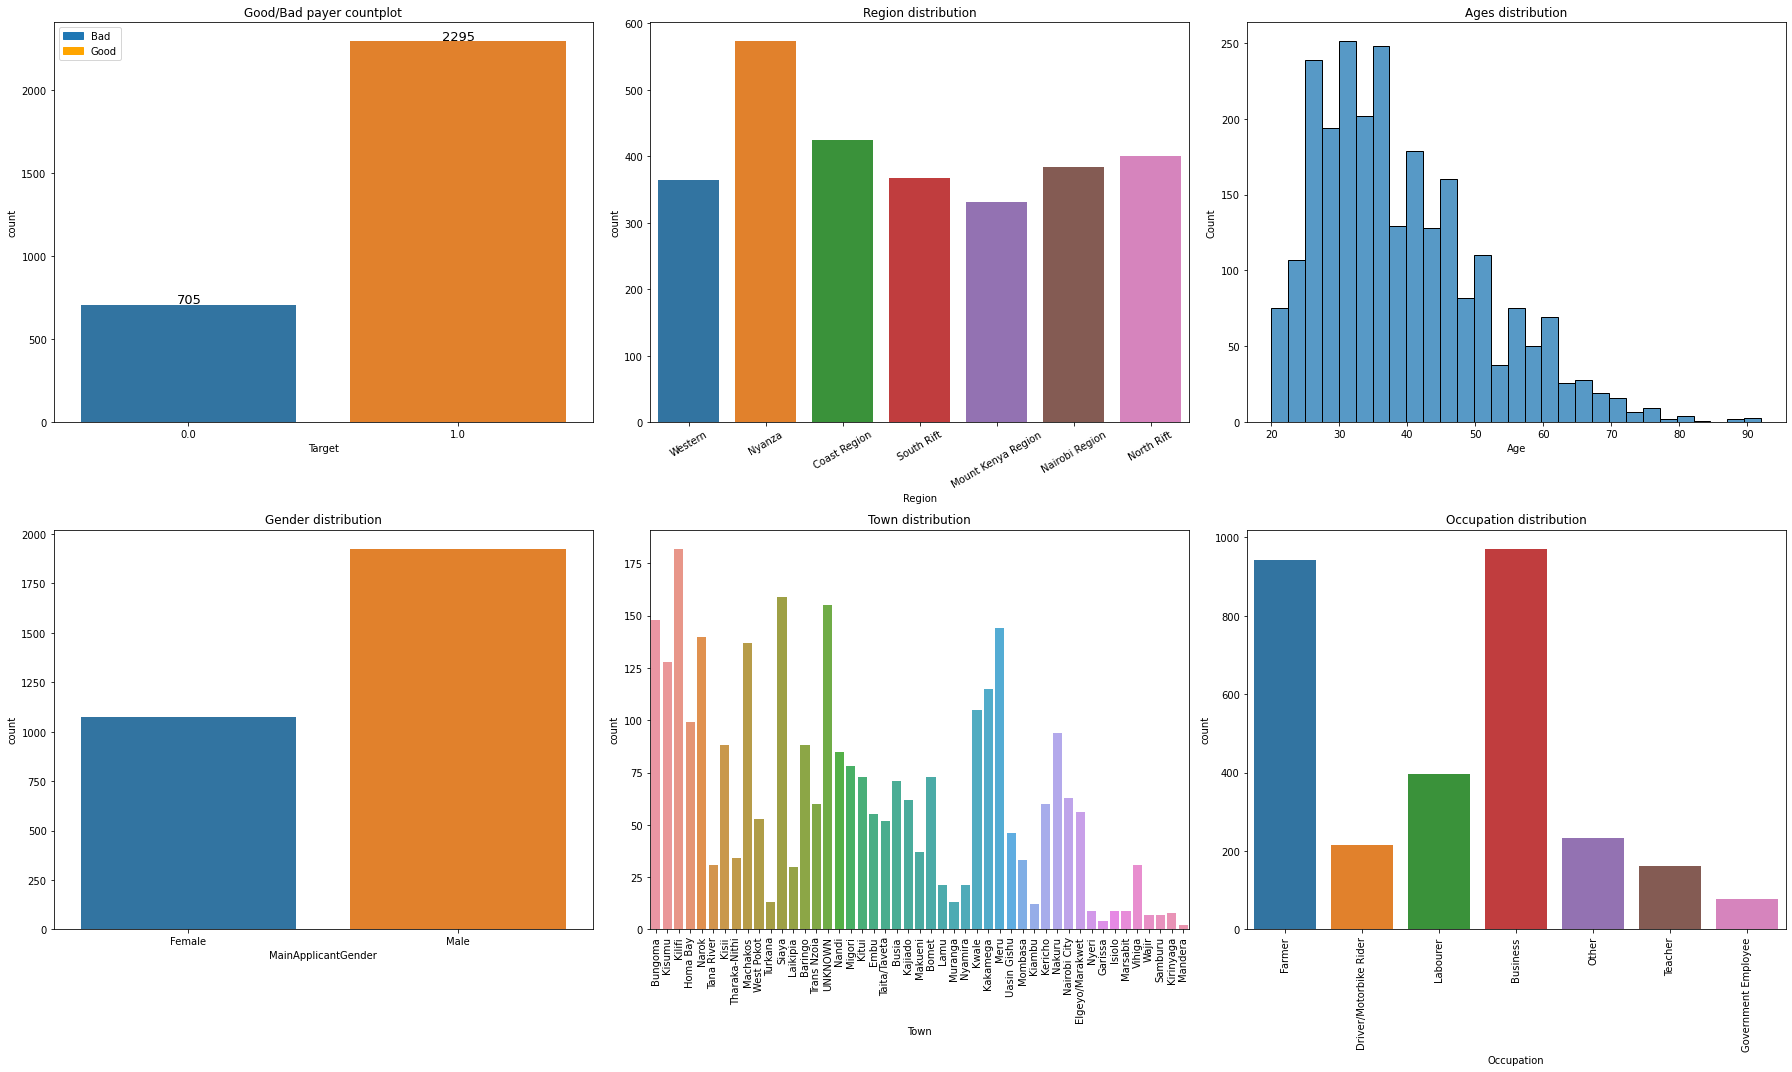

In [18]:
merged = create_target(df=merged, window=4)

### some visualization
fig = get_viz(df=merged)

### Preprocessing

In [19]:
merged_ = preprocess_data(df=merged, skip_cols=["PaymentsHistory", "TransactionDates"])

Processing datetime columns 	: 100%|██████████| 5/5 [00:00<00:00, 444.47it/s]


In [20]:
merged_.isna().sum()

ID                     0
RegistrationDate       0
Deposit                0
UpsellDate             0
AccessoryRate          0
PaymentMethod          0
rateTypeEntity         0
RatePerUnit            0
DaysOnDeposit          0
MainApplicantGender    0
Age                    0
Region                 0
Town                   0
Occupation             0
SupplierName           0
Term                   0
TotalContractValue     0
ExpectedTermDate       0
FirstPaymentDate       0
LastPaymentDate        0
TransactionDates       0
PaymentsHistory        0
m1                     0
m2                     0
m3                     0
m4                     0
m5                     0
m6                     0
Target                 0
dtype: int64

### Features extraction

In [21]:
merged_ = extract_features(df=merged_)
merged_.head(n=2)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,PaymentMethod,rateTypeEntity,RatePerUnit,DaysOnDeposit,MainApplicantGender,...,TotalContractValue,ExpectedTermDate,FirstPaymentDate,LastPaymentDate,Target,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,LastPaymentMonth,FirstPaymentMonth
0,ID_ECQME2K,2017-09-14 09:37:03,2000,None,0.0,0,0,40,7,0,...,16560.0,2022-09-08 09:37:03,2017-09-14 09:37:03,2018-12-30 09:20:00,0.0,0.0,0.0,0.0,12,9
1,ID_3CU8FA2,2020-01-10 13:01:49,2000,None,0.0,0,0,40,3,1,...,12800.0,2023-09-21 13:01:49,2020-01-10 13:01:57,2021-05-05 10:25:15,1.0,1.0,0.0,0.0,5,1


In [22]:
selected_features = [c for c in merged_.columns[1:] if "Date" not in c]
xtrain_loan = merged_[selected_features]
ytrain_loan = merged_.Target
## Split
xtrain_loan, xval_loan, ytrain_loan, yval_loan = train_test_split(
    xtrain_loan, 
    ytrain_loan, 
    test_size=.3, 
    random_state=21, 
    shuffle=True
)
scaler = StandardScaler()
##Fit scaler
scaler.fit(X=xtrain_loan.values)

## Scale data
xtrain_loan = scaler.transform(X=xtrain_loan.values)
xval_loan = scaler.transform(X=xval_loan.values)

print(f"> Training inputs shape : {xtrain_loan.shape}, Training targets shape : {ytrain_loan.shape}")
print(f"> Validation inputs shape : {xval_loan.shape}, Training targets shape : {yval_loan.shape}")

> Training inputs shape : (2100, 20), Training targets shape : (2100,)
> Validation inputs shape : (900, 20), Training targets shape : (900,)


### Train/Val split

In [23]:
train, max_len = pad_history(df=train, max_len=41)

xtrain = train.PaymentsHistory.values
ytrain = train[train.columns[-6:]].values

xs = np.array(xtrain.tolist()).reshape((xtrain.shape[0], 1, max_len))
ys = np.array(ytrain.tolist()).reshape((ytrain.shape[0], 1, 6))

train_ds = tf.data.Dataset.from_tensor_slices((xs, ys))

In [24]:
for sample in train_ds:
    print(sample)
    break

(<tf.Tensor: shape=(1, 41), dtype=float64, numpy=
array([[  55.,  110.,  240.,  900., 1330., 1190.,  160., 1570., 2000.,
         170.,  235., 1505.,  200., 1075.,  715.,  550., 1405.,  120.,
         180., 1365.,   55.,   55.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]])>, <tf.Tensor: shape=(1, 6), dtype=float64, numpy=array([[ 110., 1650., 1500.,   50.,  165., 3000.]])>)


## Modelling

In [25]:
def build_model():
    
    payments_inp = keras.Input(shape=(41), name="payments_inputs")
    status_inp = keras.Input(shape=(xtrain_loan.shape[1]), name="status_inputs")
    
    x1 = keras.layers.Dense(35, activation="sigmoid", name="x1")(status_inp)
    out1 = keras.layers.Dense(1, name="loan_status_out")(x1)
    
    
    x2 = keras.layers.Dense(20, activation="sigmoid", name="x2")(payments_inp)
    x2_out = keras.layers.Dense(30, activation="sigmoid", name="payment_out")(x2)
    
    concat = keras.layers.Concatenate(name="concat_layer")([out1, x2_out])
    out2 = keras.layers.Dense(6, name="out")(concat)
    
    # Model
    model = keras.Model(inputs=[payments_inp, status_inp], outputs=[out1, out2])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    wgt = {"out1":.7, "out2":.3}
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
        loss_weights=wgt
    )

    model.summary()
    
    return model


def build_simple_model():
    
    payments_inp = keras.Input(shape=(41), name="payments_inputs")

    x = keras.layers.Dense(20, activation="sigmoid", name="x2")(payments_inp)
    x_out = keras.layers.Dense(30, activation="sigmoid", name="payment_out")(x)
    
    out = keras.layers.Dense(6, name="out")(x)
    
    # Model
    model = keras.Model(inputs=[payments_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

    model.summary()
    
    return model


def build_status_model():
    
    status_inp = keras.Input(shape=(xtrain_loan.shape[1]), name="status_inputs")

    x = keras.layers.Dense(20, activation="sigmoid", name="x2")(status_inp)
    x_out = keras.layers.Dense(30, activation="sigmoid", name="statut_out")(x)
    
    out = keras.layers.Dense(6, name="out")(x)
    
    # Model
    model = keras.Model(inputs=[status_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

    model.summary()
    
    return model



In [26]:
model = build_simple_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
payments_inputs (InputLayer) [(None, 41)]              0         
_________________________________________________________________
x2 (Dense)                   (None, 20)                840       
_________________________________________________________________
out (Dense)                  (None, 6)                 126       
Total params: 966
Trainable params: 966
Non-trainable params: 0
_________________________________________________________________


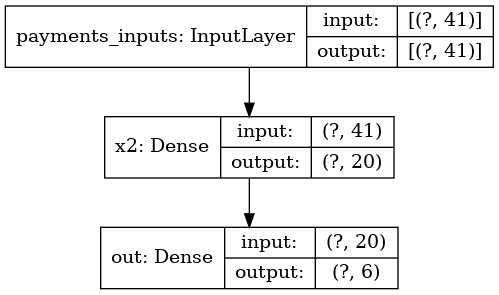

In [27]:
tf.keras.utils.plot_model(
        model,
        to_file="../model.png", 
        show_shapes=True
    )

## Learning phase

In [28]:
model.fit(train_ds, batch_size=16, epochs=2)

Epoch 1/2
2250/2250 [==============================] - 2s 993us/step - loss: 1619204.3750
Epoch 2/2
2250/2250 [==============================] - 2s 1ms/step - loss: 1277944.3750


## Eval/Inference time

In [29]:
def predict(test:pd.DataFrame):
    test, max_len = pad_history(df=test, max_len=41)

    xtest = test.PaymentsHistory.values
    xtest = np.array(xtest.tolist()).reshape((xtest.shape[0], 1, max_len))
    
    test_ds = tf.data.Dataset.from_tensor_slices(xtest)
    preds = model.predict(test_ds)
    
    assert preds.shape[0] == test.shape[0], f"Shape mismatch, {preds.shape[0]} predictions found while test set has {test.shape[0]} rows"
    
    return preds.flatten()

In [30]:
preds = predict(test=test)

In [31]:
preds.shape, ss.shape

((4500,), (4500, 2))

## Create submission

In [32]:
ss.head(n=12)

,ID,Target
0,ID_ECQME2K x m1,0.0
1,ID_ECQME2K x m2,0.0
2,ID_ECQME2K x m3,0.0
3,ID_ECQME2K x m4,0.0
4,ID_ECQME2K x m5,0.0
5,ID_ECQME2K x m6,0.0
6,ID_2TE361R x m1,0.0
7,ID_2TE361R x m2,0.0
8,ID_2TE361R x m3,0.0
9,ID_2TE361R x m4,0.0


In [33]:
ss["Target"] = preds

In [34]:
ss.head(n=12)

,ID,Target
0,ID_ECQME2K x m1,469.827728
1,ID_ECQME2K x m2,495.836853
2,ID_ECQME2K x m3,495.337036
3,ID_ECQME2K x m4,500.100677
4,ID_ECQME2K x m5,480.187042
5,ID_ECQME2K x m6,502.291748
6,ID_2TE361R x m1,425.901306
7,ID_2TE361R x m2,447.836456
8,ID_2TE361R x m3,447.367310
9,ID_2TE361R x m4,451.163483


In [35]:
ss.to_csv('../submissions/baseline_sub.csv', index=False)

### some insights

1. !!! You must then build a machine learning model that returns the expected future payments for `n` months ahead !!! (Make sure one will be able to predict for more steps with your model and `set n=6 for this competition`)⚠️

2. Building a loan status predictor is highly recommended (likelihood of being a good/bad payer)✅

3. gradient boosting? random forest? reccurent net? even use an ensemble of many models. be creative 💡!

4. Cross validation ? why not 🤷🏾‍♂️

5. You can even try a Seq2Seq model : [resource](https://awaywithideas.com/keras-implementation-of-a-sequence-to-sequence-model-for-time-series-prediction-using-an-encoder-decoder-architecture/)

In [ ]:
# Fitting a different model
# XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
xgb.fit(xtrain_loan, ytrain_loan)

xgb_preds = xgb.predict(xval_loan)

xgb_preds.shape, yval_loan.shape

from sklearn.metrics import mean_squared_error, r2_score
1 - r2_score(yval_loan, xgb_preds)

In [ ]:
# Submission
